**FINAL PROGRAM**

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from tensorflow.keras.callbacks import Callback
import os
import numpy as np
from tensorflow.keras.preprocessing import image

In [18]:
class CustomEarlyStopping(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Periksa nilai accuracy dan val_accuracy
        if logs.get('accuracy') > 0.97 and logs.get('val_accuracy') > 0.92:
            print("\nTraining dihentikan karena accuracy dan val_accuracy telah mencapai lebih dari 90%!")
            self.model.stop_training = True

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

In [4]:
# Path ke dataset
dataset_path = "/content/drive/MyDrive/ZN Staining"

In [5]:
# Fungsi untuk menghitung jumlah gambar pada setiap label
def count_images_per_label(dataset_path):
    labels = os.listdir(dataset_path)
    counts = {}
    for label in labels:
        label_path = os.path.join(dataset_path, label)
        counts[label] = len(os.listdir(label_path))
    return counts

In [6]:
# Menghitung jumlah gambar pada setiap label
counts = count_images_per_label(dataset_path)
print("Jumlah gambar per label sebelum augmentasi:", counts)

Jumlah gambar per label sebelum augmentasi: {'Over': 18, 'Good': 76, 'Less': 40}


In [7]:
# Tentukan target jumlah gambar per label
target_count = 100

In [8]:
# Augmentasi data untuk menyeimbangkan jumlah gambar pada setiap label
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [9]:
def augment_images(label_path, target_count):
    images = os.listdir(label_path)
    current_count = len(images)

    # Jika jumlah gambar sudah mencapai atau melebihi target, hapus gambar yang berlebih
    if current_count >= target_count:
        for img_name in images[target_count:]:
            img_path = os.path.join(label_path, img_name)
            os.remove(img_path)
        return

    # Jika jumlah gambar kurang dari target, lakukan augmentasi
    needed_count = target_count - current_count
    for img_name in images[:needed_count]:
        img_path = os.path.join(label_path, img_name)
        img = image.load_img(img_path)
        x = image.img_to_array(img)
        x = x.reshape((1,) + x.shape)

        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=label_path, save_prefix='aug', save_format='jpeg'):
            i += 1
            if i >= 1:  # Hanya menghasilkan satu gambar augmentasi per gambar asli
                break

In [10]:
# Augmentasi dataset untuk setiap label
labels = os.listdir(dataset_path)
for label in labels:
    label_path = os.path.join(dataset_path, label)
    augment_images(label_path, target_count)

# Menghitung jumlah gambar pada setiap label setelah augmentasi
counts = count_images_per_label(dataset_path)
print("Jumlah gambar per label setelah augmentasi:", counts)

Jumlah gambar per label setelah augmentasi: {'Over': 36, 'Good': 100, 'Less': 80}


In [12]:
# Augmentasi data untuk training dan validation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 80% training, 20% validation
)

In [13]:
# Generator untuk data training
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Found 173 images belonging to 3 classes.


In [14]:
# Generator untuk data validation
validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 43 images belonging to 3 classes.


In [15]:
# Build model CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 kelas: good, less, over
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
# Inisialisasi custom callback
custom_early_stopping = CustomEarlyStopping()

In [21]:
# Training model dengan custom callback
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50,
    callbacks=[custom_early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step - accuracy: 0.4602 - loss: 1.3972 - val_accuracy: 0.5938 - val_loss: 0.9142
Epoch 2/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.6562 - loss: 0.6581

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6562 - loss: 0.6581 - val_accuracy: 0.8750 - val_loss: 0.5407
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 7s/step - accuracy: 0.7475 - loss: 0.5300 - val_accuracy: 0.8750 - val_loss: 0.2413
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8125 - loss: 0.4279 - val_accuracy: 0.8438 - val_loss: 0.3392
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 82s 10s/step - accuracy: 0.8633 - loss: 0.3391 - val_accuracy: 0.8438 - val_loss: 0.3210
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 808ms/step - accuracy: 0.8462 - loss: 0.4996 - val_accuracy: 0.9375 - val_loss: 0.1308
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 81s 11s/step - accuracy: 0.8891 - loss: 0.2746 - val_accuracy: 0.8750 - val_loss: 0.1906
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 625ms/step - accuracy: 0.8438 - loss: 0.4473 - val_accuracy: 0.8438 - val_loss: 0.2649
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.9151 - loss: 0.2244 - val_accuracy: 0.9062 - val_loss: 0.1999
Epoch 10/50
5/

In [22]:
# Eval model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 669ms/step - accuracy: 0.9327 - loss: 0.1469
Validation Loss: 0.15667620301246643
Validation Accuracy: 0.930232584476471


In [23]:
# Simpan model terakhir (klo mau)
model.save('/content/drive/My Drive/hasil_testing_dahak/model3.h5')

Saving IMG_2799.JPG to IMG_2799.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


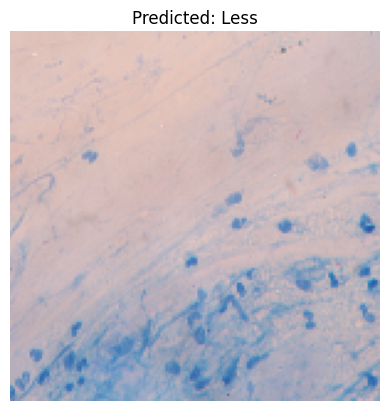

Prediction Confidence: [1.4230117e-01 8.5752726e-01 1.7149030e-04]
Predicted Class: Less


In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files

# Load model yang telah dilatih
model = tf.keras.models.load_model("/content/drive/My Drive/hasil_testing_dahak/model3.h5")

# Upload gambar melalui Colab
uploaded = files.upload()

# Get the filename of the uploaded image
img_path = list(uploaded.keys())[0]

# Load dan proses gambar
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Prediksi
predictions = model.predict(img_array)
class_labels = ["Good", "Less", "Over"]
predicted_class = class_labels[np.argmax(predictions)]

# Hasil
plt.imshow(img)
plt.title(f"Predicted: {predicted_class}")
plt.axis("off")
plt.show()

print(f"Prediction Confidence: {predictions[0]}")
print(f"Predicted Class: {predicted_class}")